# Challenge Neural Works

## Introducción

Dentro de este notebook, se encuentra la solución en su completitud al item 1 y parcialmente al item 2. Para una correcta ejecución del la solución, se debe correr primero las celdas de la sección **Script de despliegue**.

## Script de despliegue

En esta sección se instalan las librerías necesarias para el correcto funcionamiento de la solución, además de configurar la base de datos con el modelo utilizado para el desarrollo del problema.

Instalación de las librerías de machine learning, de utilidad y comunicación con la base de datos en postgres.

In [1]:
!pip install numpy pandas psycopg2-binary scikit-learn matplotlib

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/f0/5a/9b7b7bae29f9f5f8a976607cd30139c1fec9076c0e65ea918d3400924acf/numpy-1.25.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/d0/28/88b81881c056376254618fad622a5e94b5126db8c61157ea1910cd1c040a/pandas-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.5 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/1f/ad/9799aabeabcb9a293c87b6f96cc78655b8abc7d35560cd99007093b5d445/scikit_learn-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/4f/d7/3303f11188122f66c940056f162d030992e7fbc9c702869bab163e85156b/matplotlib-3.7.2-cp31

Importación de las librerías que se utilizarán en el desarrollo de la solución.

In [2]:
import time
import numpy as np
import pandas as pd
import requests
import datetime
import psycopg2
import matplotlib.pyplot as plt

from json import loads
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN, OPTICS, MeanShift
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

Definición de funciones importantes para la configuración incial.

In [3]:
#########################################################################################################
#
# Función utilizada para realizar una conección directa con Postgres para poder construir la base de
# datos a utilizar en la solución.
#
#########################################################################################################
def create_db():
    # Conexion con postgres mediante la libreria de psycopg2
    connection_db = psycopg2.connect(user = "postgres", 
                            host= 'postgres',
                            password = "nw_challenge",
                            port = 5432
                           )

    # definicion de estado, en el cual no es necesario realizar los commit de las queries
    connection_db.autocommit = True

    # definicion del cursos para el manejo de las queries
    cursor_db = connection_db.cursor()

    # definicion de la query a realizar, para crear la base de datos
    sql_query = "CREATE database challenge"

    # ejecucion de la query
    cursor_db.execute(sql_query)

    # cerrando la conexion con postgres
    connection_db.close()
    
    return None

#########################################################################################################
#
# Función utilizada para establecer la conexion con postgres y la base de datos principal para la 
# solucion del problema. La función entrega la conexion realizada con la base de datos
#
#########################################################################################################
def connection_to_db():
    # definicion de la conexion con la base de datos "challenge" con sus respectivas credenciales
    connection_db = psycopg2.connect(database = "challenge", 
                            user = "postgres", 
                            host= 'postgres',
                            password = "nw_challenge",
                            port = 5432
                           )
    return connection_db

#########################################################################################################
#
# Función utilizada para crear solamente una tabla para el modelo de datos en la bd de Postgres
#
#########################################################################################################
def create_table():
    # obtener la comunicacion con la bd y definicion del cursos
    connection_db = connection_to_db()
    cursor_db = connection_db.cursor()

    # establecer la query a realizar, la cual corresponde a la creacion de la tabla para el manejo 
    # de datos
    cursor_db.execute("""CREATE TABLE trips(
                trip_id SERIAL PRIMARY KEY,
                region VARCHAR (50) NOT NULL,
                datasource VARCHAR (50) NOT NULL,
                origin_coord VARCHAR (100) NOT NULL,
                destination_coord VARCHAR (100) NOT NULL,
                datetime TIMESTAMP NOT NULL,
                cluster INT NOT NULL);
                """)
    # realizar el commit de la query
    connection_db.commit()

    # cerrar conexiones
    cursor_db.close()
    connection_db.close()
    return None

#########################################################################################################
#
# Función utilizada eliminar todos los registros de una tabla *table* que es entregada por parametros
#
#########################################################################################################
def delete_all_records(table):
    # obtener la comunicacion con la bd y definicion del cursos
    connection_db = connection_to_db()
    cursor_db = connection_db.cursor()
    # realizacion de la query para eliminar todos los elementos presentes en la tabla *table*
    cursor_db.execute(
        f"DELETE FROM {table}"
    );

    # realizacion del commit de la query junto con el cierre de todas las conexiones a la bd
    connection_db.commit()
    cursor_db.close()
    connection_db.close()
    return None


#########################################################################################################
#
# Función utilizada para insertar todos los registros presentes en el dataframe *df*, el cual sigue el
# modelo de la tabla "trips".
#
#########################################################################################################
def insert_records_from_df(df):
    # obtener la comunicacion con la bd y definicion del cursos
    connection_db = connection_to_db()
    cursor_db = connection_db.cursor()

    # iteracion por todos los documentos del dataframe
    for index in df.index:

        # realizacion de la query para insertar un registro en la tabla "trips"
        cursor_db.execute(
            f"""INSERT INTO 
            trips(region, origin_coord, destination_coord, datetime, datasource, cluster) 
            VALUES('{df['region'][index]}', '{df['origin_coord'][index]}', '{df['destination_coord'][index]}', '{df['datetime'][index]}', '{df['datasource'][index]}', '{df['cluster'][index]}')"""
        );

    # realizacion del commit de la query junto con el cierre de todas las conexiones a la bd
    connection_db.commit()
    cursor_db.close()
    connection_db.close()
    return None

Celdas para ejecutar la configuración inicial del ambiente y la base de datos.

In [4]:
create_db()

In [5]:
create_table()

In [6]:
delete_all_records('trips')

## 1° Item

Este problema se basa en la extracción de datos desde un archivo .csv y su posterior almacenamiento en una base de datos basada en SQL, donde se debe agrupar los registros que sean similaren en cuanto a su origen, destino y hora del día. 

Para solucionar este problema, primera que nada se realizó un enfoque en limpiar y manejar los datos de una forma más comoda para que sean procesadas. Para esto, se extraen las componentes *x* e *y* de las coordenadas de origen y destino de los viajes, además de extraer solamente la hora del timestamp presente en cada registro. Una vez que los datos hayan sido limpiados y procesados, el problema se resume a realizar un clustering de los datos, por lo que se procede con una normalización de los datos, para que la diferencia de escalas entre los diferentes features no sea un factor negativo a la hora de realizar el cluster. Para el cluster se utilizará el algoritmo MeanShift, dado que permite una escalabilidad por su alto desempeño en clustering de baja dimensionalidad y dado que es un problema de clustering en el cual no se sabe con certeza cuantos clusters serán.

In [52]:
#########################################################################################################
#
# Función para convertir el string de la coordenada *point_string* en una tupla de floats
#
#########################################################################################################
def point_string_to_point(point_string):
    _, x, y = point_string.split(' ')
    return float(x[1:]), float(y[:-1])

#########################################################################################################
#
# Función utilizada para extraer la hora desde el timestamp
#
#########################################################################################################
def datetime_to_hour(d):
    return (d.timetuple()).tm_hour

#########################################################################################################
#
# Función utilizada para realizar una limpieza del archivo con los viajes
#
#########################################################################################################
def clean_df(df):
    # realizar una barrida de los registros donde se encuentren indefinidos o nan
    cleaned_df = df.dropna()[['origin_coord', 'destination_coord', 'datetime']]
    # conversion de las coordenadas a dos nuevas columnas con sus componentes cartesianas
    cleaned_df[['origin_coord_x', 'origin_coord_y']] = cleaned_df['origin_coord'].apply(point_string_to_point).to_list()
    cleaned_df[['destination_coord_x', 'destination_coord_y']] = cleaned_df['destination_coord'].apply(point_string_to_point).to_list()
    # extraccion de la hora del timestamp
    cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime']).apply(datetime_to_hour)
    cleaned_df = cleaned_df.drop(['origin_coord', 'destination_coord'], axis=1)
    return cleaned_df

Lectura del archivo de prueba

In [48]:
df = pd.read_csv('trips.csv')

In [54]:
#########################################################################################################
#
# Función utilizada para realizar un pequeo analisis exploratorio de los datos presentes en el archivo
# de prueba
#
#########################################################################################################
def plot_trips(df):
    cleaned_df = clean_df(df)
    min_max_scaler = MinMaxScaler()
    normalized_datetime_minmax = min_max_scaler.fit_transform(np.array(cleaned_df['datetime']).reshape(-1, 1))
    cleaned_df['datetime'] = normalized_datetime_minmax
    fig = plt.figure(figsize=(25,25))
    plt.rcParams.update({'font.size': 24})
    plt.scatter(cleaned_df['origin_coord_x'], cleaned_df['origin_coord_y'], alpha = cleaned_df['datetime'], label="origin coords")
    plt.scatter(cleaned_df['destination_coord_x'], cleaned_df['destination_coord_y'], alpha = cleaned_df['datetime'])
    plt.title("Trips in the time")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(['origin coords', 'destination coords'], loc ="upper right")
    plt.show()
    return None

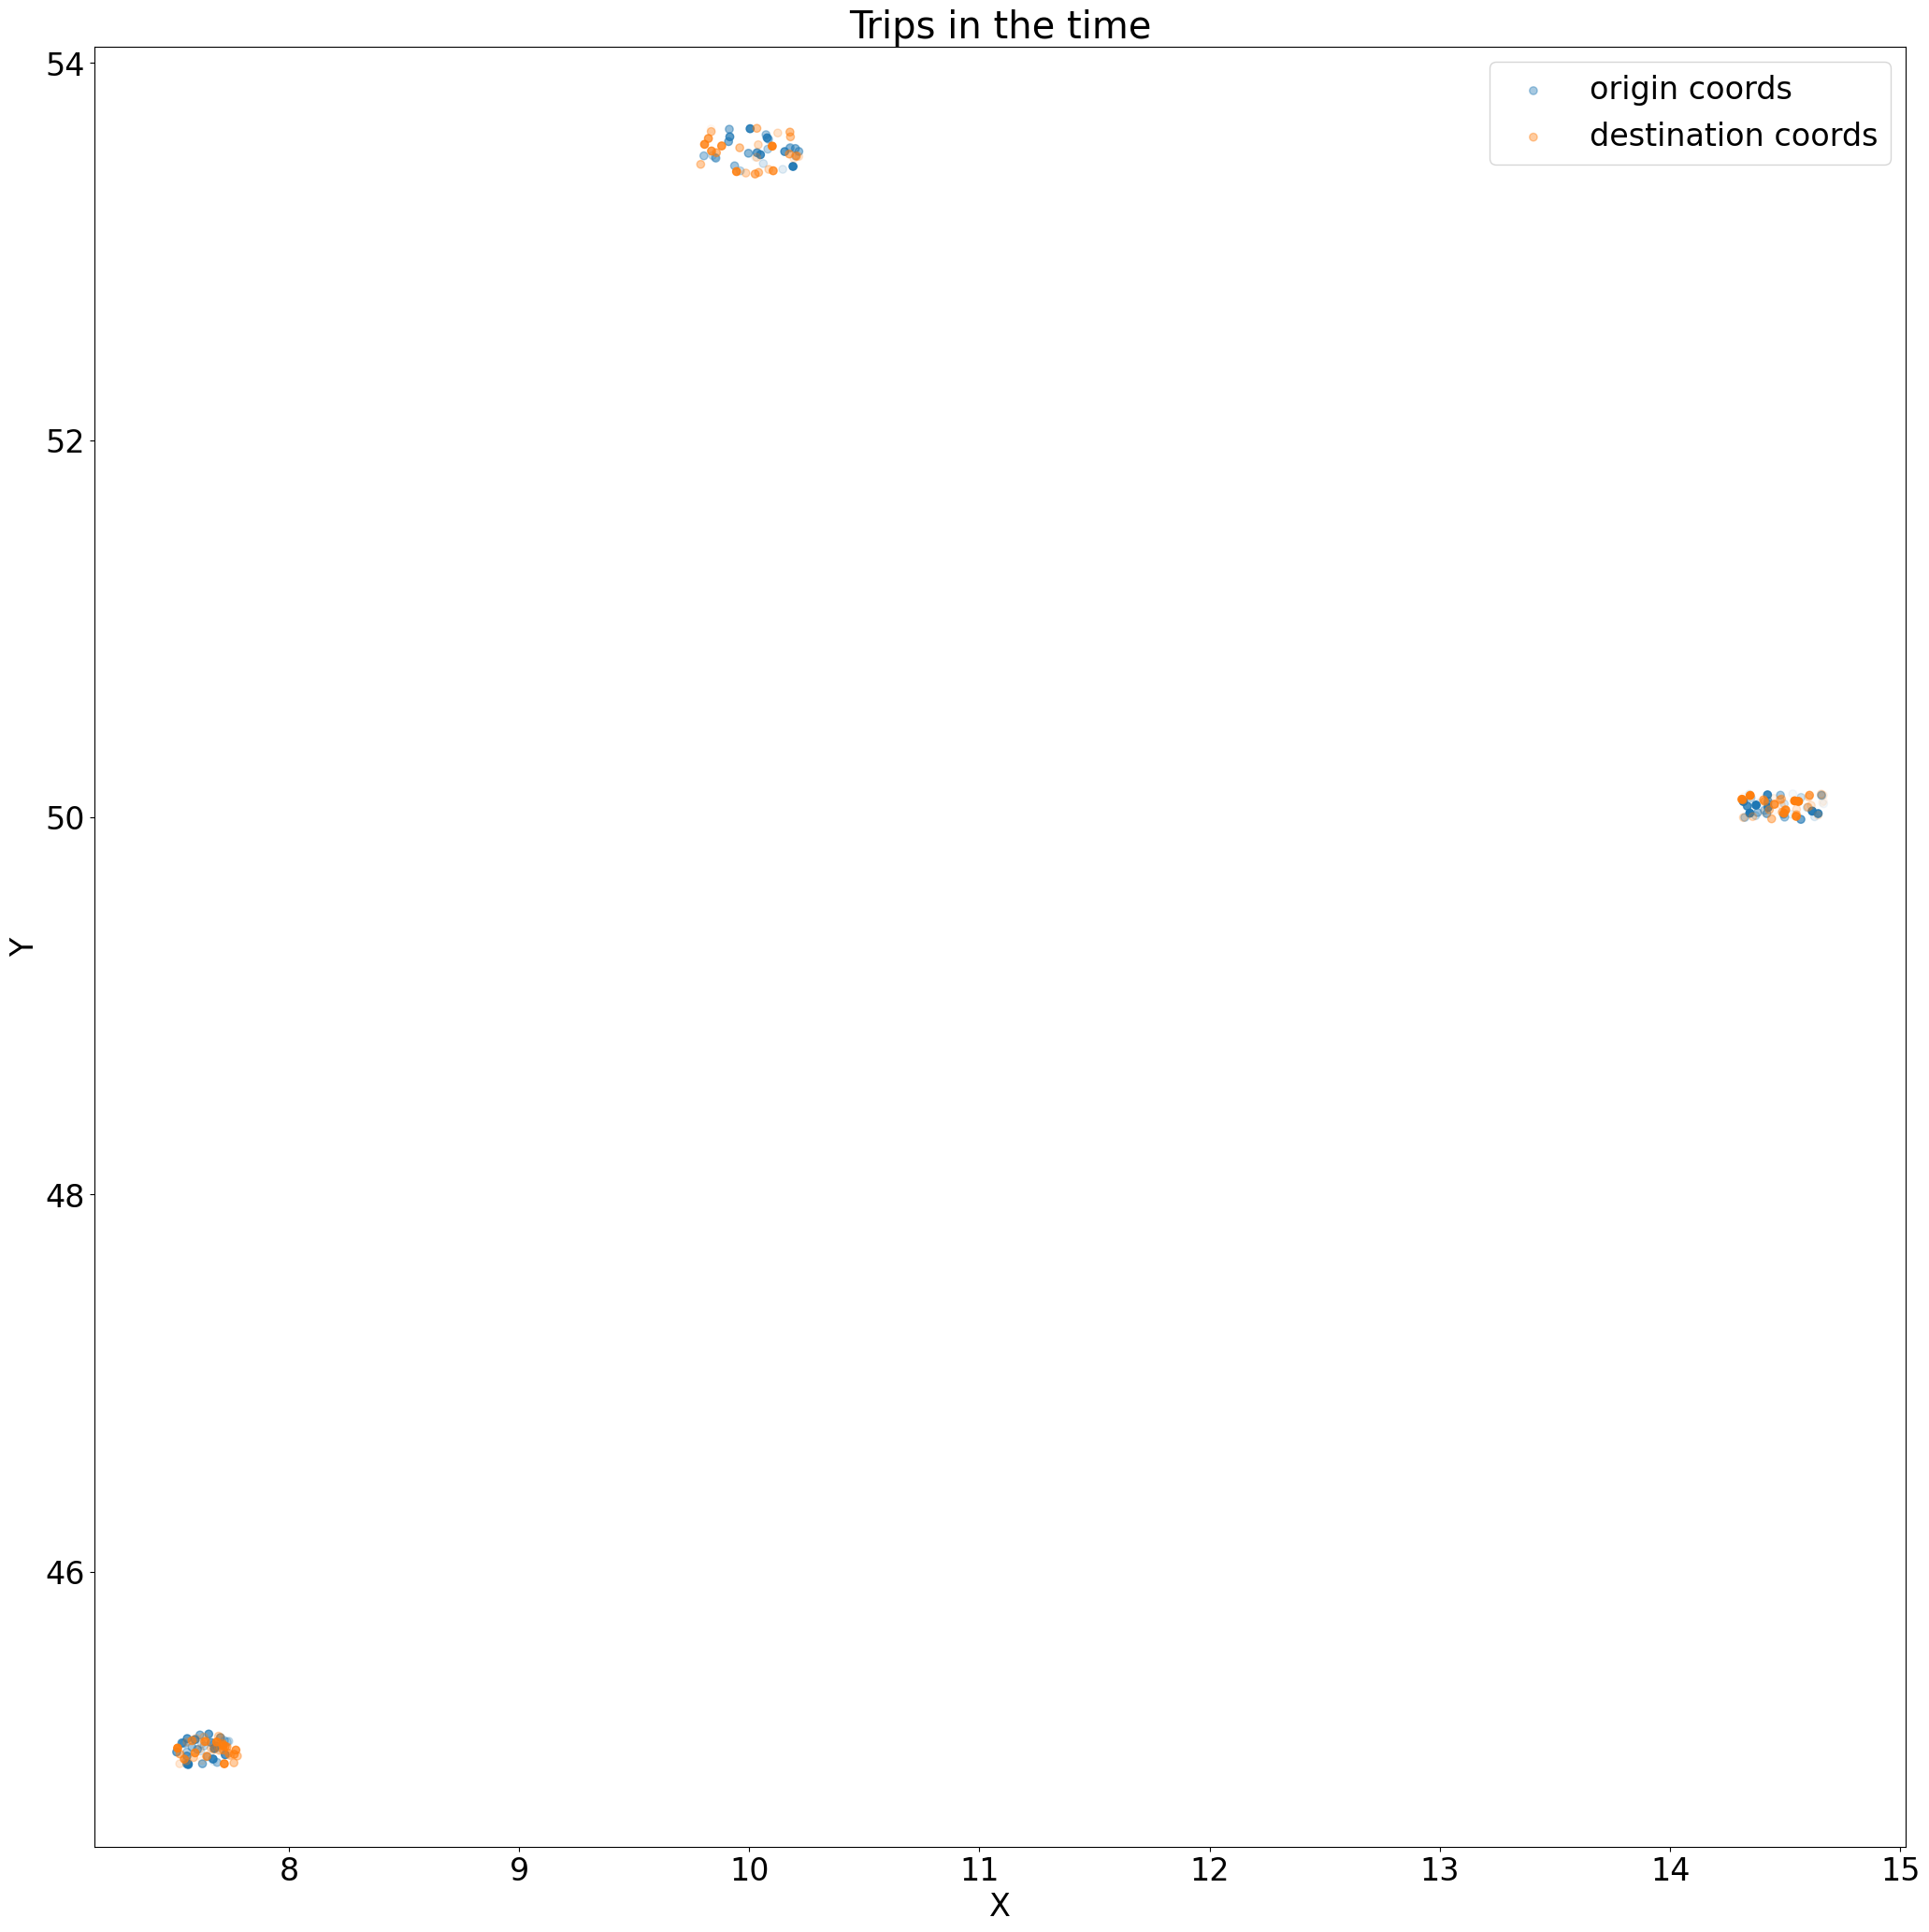

In [55]:
# plot de los datos presentes en el dataframe *df*
plot_trips(df)

Celda para el procesamiento de datos, desde su limpieza hasta su normalización de los datos, realizado con las funciones declaradas previamente.

In [12]:
# limpieza del dataframe
cleaned_df = clean_df(df)

# normalización de los datos en una escala de 0 a 1 (min max)
min_max_scaler = MinMaxScaler()
normalized_df_minmax = min_max_scaler.fit_transform(cleaned_df)
normalized_df = pd.DataFrame(normalized_df_minmax, columns=cleaned_df.columns)

normalized_df

,datetime,origin_coord_x,origin_coord_y,destination_coord_x,destination_coord_y
0,0.896871,0.976304,0.579207,0.967195,0.583318
1,0.657174,0.022324,0.002258,0.028431,0.009929
2,0.401143,0.952106,0.579052,0.973712,0.589414
3,0.171227,0.003966,0.013310,0.031917,0.005139
4,0.736812,0.014110,0.018235,0.001450,0.005954
...,...,...,...,...,...
95,0.084692,0.953693,0.585939,0.970263,0.586671
96,0.736752,0.347171,0.984997,0.371714,0.984292
97,0.367211,0.964056,0.583405,0.990677,0.584954
98,0.700889,0.359287,0.993593,0.372389,0.994799


Definición de funciones importantes para la busqueda de hiperparámetros del modelo, para buscar el mejor hiperparámetro. Para esto se realizó una segmentación de los datos en tres sets, uno de entrenamiento (70%), de validación (~20%) y testeo final (~10%). Para medir el rendimiento del modelo, se utilizará la metrica de silhouette score, dado que es una métrica típica para medir que también se realizó la clusterización de los datos.

In [13]:
#########################################################################################################
#
# Función utilizada para obtener el score mediante la metrica de silhouette
#
#########################################################################################################
def model_score(data, optics_result):
    #
    return silhouette_score(data, optics_result)

#########################################################################################################
#
# Función utilizada para realizar la iteración de los posibles hiperparametros a evaluar
#
#########################################################################################################
def hyperparameter_optimization(bandwith_options, data):
    # definicion de las variables de control
    best_score = -1.
    best_bandwith = None

    # split de los set de testeo, entrenamiento y validación
    X_train, X_test, _, _ = train_test_split(data, data, test_size=0.3, random_state=1)
    X_val, X_test, _, _ = train_test_split(X_test, X_test, test_size=0.33, random_state=1)

    # iteración por los hiperparámetros
    for bandwith_i in bandwith_options:
        # definicion del modelo
        meanshift_model = MeanShift(bandwidth = bandwith_i)

        # entrenamiento del modelo
        meanshift_model.fit(X_train)
        # predicción con el grupo de control de validación
        meanshift_result = meanshift_model.predict(X_val)

        # obtención de la metrica
        current_model_score = model_score(X_val, meanshift_result)

        # comprobación si es óptimo el valor
        if current_model_score > best_score:
            best_score = current_model_score
            best_bandwith = bandwith_i

    # comprobación final con el grupo de control de testeo final con el hiperparametro encontrado
    meanshift_model = MeanShift(bandwidth = best_bandwith)
    meanshift_model.fit(X_train)
    meanshift_result = meanshift_model.predict(X_test)
    print(f'Score final del modelo con un bandwith de {best_bandwith}: {model_score(X_test, meanshift_result)}')

    return best_bandwith, best_score


En la siguiente celda se declarará que hiperparámetro se manejará. En este caso para el modelo de Mean Shift, solo se tiene el hiperparámetro de bandwidth, el cual para esta solución, se ocilará entre [0.05, 1] variando de 0.05 entre cada intervalo. Se experimentó previamente con número mayores a 1 y la eficiencia del modelo decaia, por lo que se intué que el óptimo se pueda encontrar en ese intervalo.

In [14]:
# definicion del intervalo a utilizar
bandwith_options = [round(i*0.05, 2) for i in range(1, 21)]

# obtencion del mejor hiperparámetro
best_bandwith, best_score = hyperparameter_optimization(bandwith_options, normalized_df)
best_bandwith, best_score

Score final del modelo con un bandwith de 0.4: 0.7852820152076343


(0.4, 0.7194372659361163)

En la siguiente celda se define ya el modelo a utilizar junto con el hiperparámetro encontrado para ser entrenado inicialmente con el dataset entregado.

In [15]:
# definición del modelo final
bandwidth = best_bandwith

meanshift_model = MeanShift(bandwidth = bandwidth)

meanshift_result = meanshift_model.fit_predict(normalized_df)

df['cluster'] = meanshift_result

In [25]:
# inserción de los registros ya agrupados con el algoritmo de clustering en la base de datos en Postgres
insert_records_from_df(df)

## 2° Item

Este problema se basa en obtener todos los viajes que se encuentren dentro de una bounding box definida.

Para este problema se asume que la bounding box será un cuadrilatero y para que un viaje pertenezca a la bounding box, este debe partir y terminar dentro de esta área definida, además, se asume que el punto esta dentro si es que también esta en los límites del cuadrilatero. Para la solución a este problema, se utilizará un algoritmo empleado en clipping (el algoritmo de Cohen-Sutherland clipping), en el cual se define el estado en base a bit, en donde se encuentra un punto dentor de un área de interés, para obtener la posición de este, se utilizará una propiedad matemática relacionada con el producto cruz, en el cual, dado un vertice con una orientación dentro de un poligono y un punto en el espacio, el producto cruz entre el vertice y uno de las aristas del vertice unida al punto, el signo del resultado de este producto cruz, indicaría en donde se posiciona este punto, izquierda positivo, derecha negativo y 0 en perpendicular, por lo que, si todos los productos cruz entre un punto y los vertices de un poligono dan negativo, indica que el punto se encuentra dentro de este. Siguiendo la misma lógica, se realizó un algoritmo simple con esta premisaán

In [17]:

#########################################################################################################
#
# Función utilizada para obtener el vector de bits de un punto en el espacio frente a un cuadrilatero.
# El punto *coord*, debe realizar el producto cruz con cada vertice del cuadrilatero definido por los
# puntos *p1* y *p2*.
#
#########################################################################################################

def create_cohen_sutherland_clipping_bits(coord, p1, p2):

    # definicion de puntos necesarios para la confección de la matriz de con las operaciones de producto cruz
    p1_x, p1_y = p1
    p2_x, p2_y = p2
    x, y = coord

    # el producto cruz a realizar entre cada vertice y punto se define como x1*y2 - x2*y1, siendo (x1, y1) el par
    # de coordenadas del primer vector y (x2, y2) del segundo, por lo tanto con un arreglo de matrices, se pueden
    # realizar todas las operaciones confeccionando las siguientes matrices
    
    A = np.array(
        [
            [0, p2_y - p1_y],
            [p2_x - p1_x, 0],
            [0, p1_y - p2_y],
            [p1_x - p2_x, 0],
        ]
    )

    B = np.array(
        [
            [x - p1_x, y - p2_y],
            [x - p2_x, y - p2_y],
            [x - p2_x, y - p1_y],
            [x - p1_x, y - p1_y],
        ]
    )

    # producto cruz de los vectores
    coord_bits = np.cross(A, B)
    # definir si un punto esta dentro o fuera de la caja, en caso de cumplirse que este dentro de la bounding box, se define el vector 0
    # caso contrario el vector unitario
    coord_bits[coord_bits > 0.] = 1.
    # cabe destacar que el <= define que el punto también puede estar en el borde del cuadrilatero
    coord_bits[coord_bits <= 0.] = 0.
    
    return coord_bits

#########################################################################################################
#
# Función general utilizada para comprobar dado un viaje con un origen(*origin_coord*) y
# destino(*destination_coord*), si se encuentran ambos dentro de la bounding box definida por *p1* y *p2*
#
#########################################################################################################
def check_trip_in_bounding_box(origin_coord, destination_coord, p1, p2):

    origin_bits = create_cohen_sutherland_clipping_bits(origin_coord, p1, p2)
    destination_bits = create_cohen_sutherland_clipping_bits(destination_coord, p1, p2)

    # comprobación si ambos vectores son 0's
    return (origin_bits == destination_bits).all() and (origin_bits == np.array([0., 0., 0., 0.])).all()

In [18]:
#########################################################################################################
#
# Función utilizada para obtener en base a una tabla *table* en la bd, todos los registros que
# correspondan a la región *region*
#
#########################################################################################################
def get_record_by_region(table, region):
    # establecer conexion con la bd
    connection_db = connection_to_db()
    cursor_db = connection_db.cursor()
    # realización de la query
    cursor_db.execute(f"SELECT * FROM {table} WHERE \"region\" = '{region}'")
    # buscar todos los registros que cumplan la restriccion
    records = cursor_db.fetchall()
    # cerrando las conexiones
    cursor_db.close()
    connection_db.close()
    return records

In [19]:
#########################################################################################################
#
# Función general para obtener todos viajes presentes en una bounding box, definida por *p1* y *p2*
#
#########################################################################################################
def get_trips_by_bounding_box(records, p1, p2):
    
    records_filtered_by_bounding_box = []

    # recorrido uno por uno de los viajes
    for record in records:
        # obtenciones de las coordenadsa en tuplas de floats
        origin_coord = point_string_to_point(record[3])
        destination_coord = point_string_to_point(record[4])
        # checkeo si cumplen la restricción
        if check_trip_in_bounding_box(origin_coord, destination_coord, p1, p2):
            records_filtered_by_bounding_box.append(record)
    return records_filtered_by_bounding_box

In [20]:
#########################################################################################################
#
# Función utilizada para mostrar los registros que se encuentran dentro de una bounding box definida por
# *p1* y *p2*
#
#########################################################################################################
def plot_trips_in_bounding_box(trips, p1, p2):
    dataframe = pd.DataFrame(trips, columns=['trip_id', 'region', 'datasource', 'origin_coord', 'destination_coord', 'datetime', 'cluster'])
    cleaned_df = clean_df(dataframe)
    fig = plt.figure(figsize=(8,8))
    rectangle = plt.Rectangle(xy = p1, width = p2[0] - p1[0], height = p2[1] - p1[1], ec = "red", alpha=0.5, fill=None)
    plt.gca().add_patch(rectangle)
    
    plt.rcParams.update({'font.size': 8})
    plt.scatter(cleaned_df['origin_coord_x'], cleaned_df['origin_coord_y'], color = "blue")
    plt.scatter(cleaned_df['destination_coord_x'], cleaned_df['destination_coord_y'], color = "orange")
    plt.title("")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(['bounding box', 'origin coords', 'destination coords'], loc ="upper right")
    plt.show()
    return None

En la siguiente celda se definirá las variables a trabajar con la bounding box y la región

In [21]:
region = 'Turin'
p1_bounding_box = (7.5, 45.)
p2_bounding_box = (7.85, 45.15)

# obtención de los registros por región deseada
records_filtered_by_region = get_record_by_region('trips', region)
# obtención de los registros que se encuentran dentro de la bb
records_filtered_by_bounding_box = get_trips_by_bounding_box(records_filtered_by_region, p1_bounding_box, p2_bounding_box)

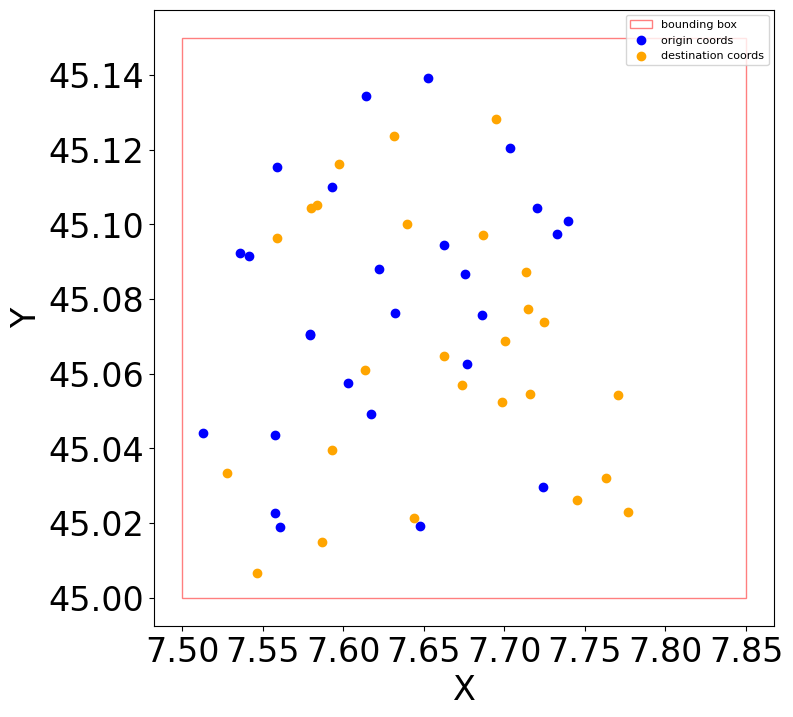

In [22]:
# llamado a la función para visualizar los puntos dentro del área de interés
plot_trips_in_bounding_box(records_filtered_by_bounding_box, p1_bounding_box, p2_bounding_box)

Para completar el siguiente requerimiento del item 2, el cual corresponde a la ingesta de datos, se dividió la solución en dos notebooks, para que un notebook actuase como un listener y el otro envié los datos que son agregados a la base de datos. En este caso, este notebook en particular cumple la función de procesar los datos y luego enviarlos al otro notebook para que puedan ser visualizados allá, cabe destacar que para que estas celdas sean accionadas, el otro notebook debe de estar en funcionamiento.

Otro comentario es sobre el procesamiento de nuevos datos entrantes. Para mantener un rendimiento, no es posible entrenar el modelo con los datos que entran, por eso, la idea de la solución de este problema es que se gaste un tiempo acotado en un entrenamiento del modelo que sea representativo de los datos y mientras no surgan una cantidad grande datos nuevos, este solamente haga una predicción de los nuevos datos entrantes para optimizar los tiempos de respuesta.

In [23]:
#########################################################################################################
#
# Función utilizada para procesar la nueva ingesta de datos provenientes desde los archivos *csv_name*
# para luego predecir que a que cluster debería de pertenecer.
#
#########################################################################################################
def upload_data(csv_name):
    #lectura y limpieza del nuevo documento de datos
    df = pd.read_csv(csv_name)
    cleaned_df = clean_df(df)

    # procesamiento de los datos para normalizarlos
    min_max_scaler = MinMaxScaler()
    normalized_df_minmax = min_max_scaler.fit_transform(cleaned_df)
    normalized_df = pd.DataFrame(normalized_df_minmax, columns=cleaned_df.columns)

    # prediccion de los datos entrantes con respecto a que cluster deberían de pertenecer
    optics_result = meanshift_model.predict(normalized_df)

    # definición del nuevo segmento de datos a ingresar a la base de datos
    df['cluster'] = meanshift_result
    insert_records_from_df(df)

    # comunicación con el otro notebook para mostrar la ingesta de datos
    data_request = loads(df.to_json(orient='records'))[::-1]    
    requests.post('http://localhost:5400/', json = data_request)
    
    return None

In [24]:
# activar una nueva ingesta de datos con un archivo csv
upload_data('trips.csv')

## 3° Requisito

Con respecto al 3 item, este se basa en que la solución sea escalable. Con respecto al diseño de la solución, los dos grandes algoritmos que podrían tardar más tiempo en procesar son la clusterización y la búsqueda de viajes dentro de una bounding box.

Con respecto a la clusterización, el algoritmo de Mean Shift frente a casos de baja dimensionalidad, presenta una cota de $O(T*n*log n)$, en donde *T* es el número de features y *n* el número de muestras para el entrenamiento, lo cual esto presenta una cota aceptable en terminos de escalabilidad, siendo baja pese a que se sacrifica un costo computacional al principio para que las predicciones futuras no sean de gran peso computacional. Además en el peor de los casos, la cota que puede cumplir el algoritmo es de $O(n^2)$, siendo aún así una cota aceptable para este enfoque mencionado.

Con respecto a la búsqueda de viajes dentro de una bounding box, la cota que presenta el algoritmo propuesto es $O(n)$, lo cual es aceptable para que las consultas que se puedan realizar para esta funcionalidad, no impacten en el rendimiento general de la solución.

Por lo tanto, frente a este análisis, se podría declarar que es escalable la solución

## Extras

Con respecto a la solución, tiene mejoras en cuanto al modelo a emplear, otros modelos podrían rendir mejor en cuanto a precisión como el algoritmo VBGMM, o utilizar algoritmos más clásicos como DBSCAN, en el cual se podrían realizar pequeñas alteraciones para que este pudiese predecir datos futuros y así mantenga la escalabilidad del sistema. Además que hay campo de mejora en cuanto a la definición de los intervales en que se volverá a entrenar el modelo para que no sea un modelo sesgado y no provoque ningún bias.